Dataset link: https://www.kaggle.com/datasets/thomasdubail/brain-tumors-256x256

### Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Images of each category

In [2]:
print("Glioma Tumor:", len(os.listdir('/kaggle/input/brain-tumors-256x256/Data/glioma_tumor')))
print("Meningioma Tumor:", len(os.listdir('/kaggle/input/brain-tumors-256x256/Data/meningioma_tumor')))
print("Normal:", len(os.listdir('/kaggle/input/brain-tumors-256x256/Data/normal')))
print("Pituitary Tumor:", len(os.listdir('/kaggle/input/brain-tumors-256x256/Data/pituitary_tumor')))

Glioma Tumor: 901
Meningioma Tumor: 913
Normal: 438
Pituitary Tumor: 844


### Loading all the images

In [3]:
X, y= [], []
for file in os.listdir('/kaggle/input/brain-tumors-256x256/Data'):
    for image in os.listdir('/kaggle/input/brain-tumors-256x256/Data/'+str(file)):
        img = cv2.imread('/kaggle/input/brain-tumors-256x256/Data/'+str(file)+str('/')+str(image))
        X.append(img)
        y.append(file)

### Converting list to array

In [4]:
X = np.array(X)
y = np.array(y)

In [5]:
X.shape

(3096, 256, 256, 3)

In [6]:
y.shape

(3096,)

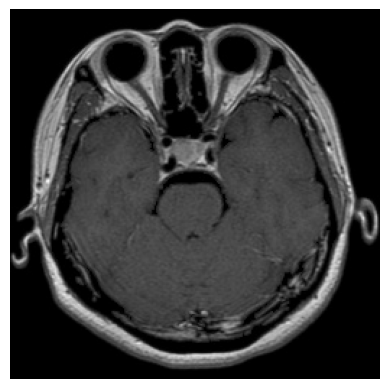

In [7]:
plt.axis("off")
plt.imshow(X[52])

### Normalization

In [8]:
X_scaled = X/255

In [9]:
X_scaled[0][158][25]

array([0.5254902, 0.5254902, 0.5254902])

### Performing one-hot encoding in y

In [10]:
ohe = LabelEncoder()

y_ohe = ohe.fit_transform(y)

In [11]:
pd.DataFrame(y_ohe).value_counts()

1    913
0    901
3    844
2    438
Name: count, dtype: int64

In [12]:
pd.DataFrame(y).value_counts()

meningioma_tumor    913
glioma_tumor        901
pituitary_tumor     844
normal              438
Name: count, dtype: int64

glioma_tumor is mapped to 0;
meningioma_tumor is mapped to 1;
normal is mapped to 2;
pituitary_tumor is mapped to 3

In [13]:
y_ohe

array([3, 3, 3, ..., 2, 2, 2])

In [14]:
y_cat = keras.utils.to_categorical(y_ohe, num_classes=4)
y_cat

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32)

### Splitting data into training and testing set

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_cat, test_size=0.2, random_state=21)

In [16]:
X_test.shape

(620, 256, 256, 3)

In [17]:
y_test.shape

(620, 4)

### Creating our model

In [49]:
model = keras.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(256,256,3)),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4, activation='softmax'),
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
             metrics=['accuracy'])

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)

### Training our model

In [50]:
model.fit(X_train, y_train, epochs=50, validation_split=0.2, batch_size=32, callbacks=[es])

Epoch 1/50
62/62 [==============================] - 7s 85ms/step - loss: 1.2177 - accuracy: 0.4480 - val_loss: 1.0137 - val_accuracy: 0.5645
Epoch 2/50
62/62 [==============================] - 4s 67ms/step - loss: 0.8812 - accuracy: 0.6328 - val_loss: 0.7919 - val_accuracy: 0.6573
Epoch 3/50
62/62 [==============================] - 4s 67ms/step - loss: 0.6735 - accuracy: 0.7500 - val_loss: 0.6482 - val_accuracy: 0.7843
Epoch 4/50
62/62 [==============================] - 4s 67ms/step - loss: 0.5126 - accuracy: 0.8035 - val_loss: 0.5385 - val_accuracy: 0.8185
Epoch 5/50
62/62 [==============================] - 4s 68ms/step - loss: 0.3445 - accuracy: 0.8677 - val_loss: 0.5388 - val_accuracy: 0.8044
Epoch 6/50
62/62 [==============================] - 4s 68ms/step - loss: 0.2333 - accuracy: 0.9096 - val_loss: 0.5043 - val_accuracy: 0.8266
Epoch 7/50
62/62 [==============================] - 4s 68ms/step - loss: 0.1287 - accuracy: 0.9571 - val_loss: 0.6208 - val_accuracy: 0.8266
Epoch 8/50
62

### Prediction for X_test

In [51]:
y_pred = model.predict(X_test)

20/20 [==============================] - 0s 21ms/step


In [52]:
y_predicted = np.argmax(y_pred, axis=1)

In [53]:
y_true = np.argmax(y_test, axis=1)

### Accuracy Score

In [54]:
accuracy_score(y_true,y_predicted)

0.8903225806451613

### Confusion Matrix

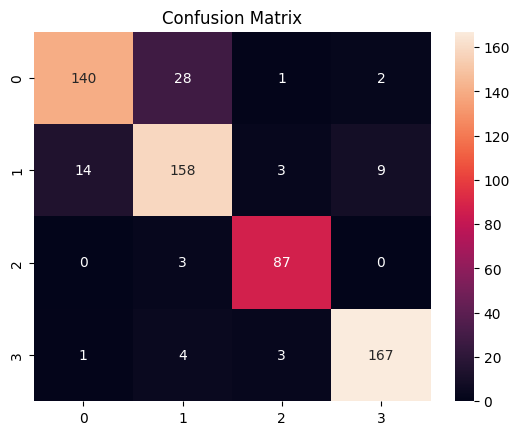

In [55]:
cm = confusion_matrix(y_true, y_predicted)

sns.heatmap(cm, annot=True,fmt=".0f")
plt.title("Confusion Matrix")
plt.show()

### Classification Report

In [56]:
print(classification_report(y_true,y_predicted))

              precision    recall  f1-score   support

           0       0.90      0.82      0.86       171
           1       0.82      0.86      0.84       184
           2       0.93      0.97      0.95        90
           3       0.94      0.95      0.95       175

    accuracy                           0.89       620
   macro avg       0.90      0.90      0.90       620
weighted avg       0.89      0.89      0.89       620



* **Accuracy Score: 0.89**
* **f1-score for 0: 0.86**
* **f1-score for 1: 0.84**
* **f1-score for 2: 0.95**
* **f1-score for 3: 0.95**

### Creating a new model with two more convolution layers and two more pooling layers

In [43]:
model1 = keras.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(256,256,3)),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Conv2D(filters=1024, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4, activation='softmax'),
])

model1.compile(optimizer='adam',
              loss='categorical_crossentropy',
             metrics=['accuracy'])

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)

### Training our model

In [44]:
model1.fit(X_train, y_train, epochs=50, validation_split=0.2, batch_size=32, callbacks=[es])

Epoch 1/50
62/62 [==============================] - 15s 135ms/step - loss: 1.3633 - accuracy: 0.2924 - val_loss: 1.3584 - val_accuracy: 0.2923
Epoch 2/50
62/62 [==============================] - 5s 78ms/step - loss: 1.2369 - accuracy: 0.3904 - val_loss: 1.0908 - val_accuracy: 0.5403
Epoch 3/50
62/62 [==============================] - 5s 79ms/step - loss: 1.0311 - accuracy: 0.5465 - val_loss: 0.8822 - val_accuracy: 0.6190
Epoch 4/50
62/62 [==============================] - 5s 79ms/step - loss: 0.8577 - accuracy: 0.6369 - val_loss: 0.7773 - val_accuracy: 0.6794
Epoch 5/50
62/62 [==============================] - 5s 79ms/step - loss: 0.7478 - accuracy: 0.6960 - val_loss: 0.7778 - val_accuracy: 0.6895
Epoch 6/50
62/62 [==============================] - 5s 79ms/step - loss: 0.5994 - accuracy: 0.7551 - val_loss: 0.5950 - val_accuracy: 0.7802
Epoch 7/50
62/62 [==============================] - 5s 79ms/step - loss: 0.4829 - accuracy: 0.8202 - val_loss: 0.4929 - val_accuracy: 0.7823
Epoch 8/50


### Prediction for X_test

In [45]:
y_pred = model1.predict(X_test)
y_predicted = np.argmax(y_pred, axis=1)

20/20 [==============================] - 1s 43ms/step


### Accuracy Score

In [46]:
accuracy_score(y_true,y_predicted)

0.85

### Confusion Matrix

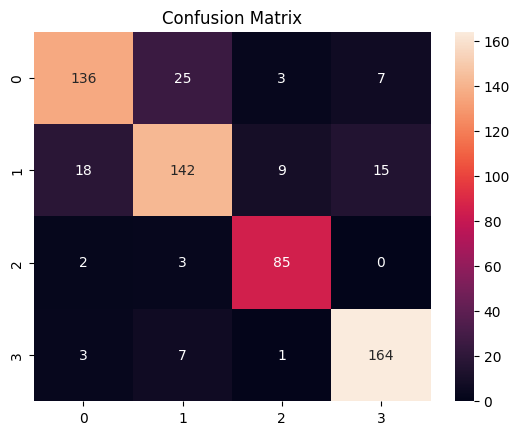

In [47]:
cm = confusion_matrix(y_true, y_predicted)

sns.heatmap(cm, annot=True,fmt=".0f")
plt.title("Confusion Matrix")
plt.show()

### Classification Report

In [48]:
print(classification_report(y_true,y_predicted))

              precision    recall  f1-score   support

           0       0.86      0.80      0.82       171
           1       0.80      0.77      0.79       184
           2       0.87      0.94      0.90        90
           3       0.88      0.94      0.91       175

    accuracy                           0.85       620
   macro avg       0.85      0.86      0.86       620
weighted avg       0.85      0.85      0.85       620



* **Accuracy Score: 0.85**
* **f1-score for 0: 0.82**
* **f1-score for 1: 0.79**
* **f1-score for 2: 0.90**
* **f1-score for 3: 0.91**

### Using Pre-trained Model VGG16

In [34]:
from tensorflow.keras.applications.vgg16 import VGG16

In [35]:
vgg16 = VGG16(input_shape=(256,256,3), weights='imagenet', include_top=False)

for layer in vgg16.layers:
    layer.trainable = False
    
x = keras.layers.Flatten()(vgg16.output)

prediction = keras.layers.Dense(4, activation='softmax')(x)

model2 = keras.Model(inputs=vgg16.input, outputs=prediction)

58889256/58889256 [==============================] - 0s 0us/step


In [36]:
model2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

### Training our model

In [37]:
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model2.fit(X_train, y_train, epochs=50, validation_split=0.2, batch_size=32, callbacks=[es])

Epoch 1/50
62/62 [==============================] - 28s 360ms/step - loss: 1.1294 - accuracy: 0.6429 - val_loss: 0.6856 - val_accuracy: 0.7258
Epoch 2/50
62/62 [==============================] - 13s 204ms/step - loss: 0.4066 - accuracy: 0.8460 - val_loss: 0.3526 - val_accuracy: 0.8669
Epoch 3/50
62/62 [==============================] - 12s 198ms/step - loss: 0.2108 - accuracy: 0.9303 - val_loss: 0.3590 - val_accuracy: 0.8669
Epoch 4/50
62/62 [==============================] - 12s 196ms/step - loss: 0.1281 - accuracy: 0.9722 - val_loss: 0.2668 - val_accuracy: 0.9052
Epoch 5/50
62/62 [==============================] - 12s 196ms/step - loss: 0.1011 - accuracy: 0.9803 - val_loss: 0.2683 - val_accuracy: 0.9093
Epoch 6/50
62/62 [==============================] - 12s 196ms/step - loss: 0.0737 - accuracy: 0.9944 - val_loss: 0.2850 - val_accuracy: 0.8931
Epoch 7/50
62/62 [==============================] - 12s 198ms/step - loss: 0.0556 - accuracy: 0.9975 - val_loss: 0.2892 - val_accuracy: 0.9073

### Prediction for X_test

In [39]:
y_pred = model2.predict(X_test)
y_predicted = np.argmax(y_pred, axis=1)

20/20 [==============================] - 5s 279ms/step


### Accuracy Score

In [40]:
accuracy_score(y_true,y_predicted)

0.9225806451612903

### Confusion Matrix

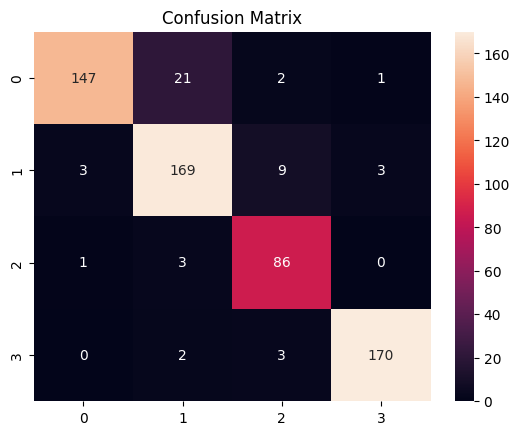

In [41]:
cm = confusion_matrix(y_true, y_predicted)

sns.heatmap(cm, annot=True,fmt=".0f")
plt.title("Confusion Matrix")
plt.show()

### Classification Report

In [42]:
print(classification_report(y_true,y_predicted))

              precision    recall  f1-score   support

           0       0.97      0.86      0.91       171
           1       0.87      0.92      0.89       184
           2       0.86      0.96      0.91        90
           3       0.98      0.97      0.97       175

    accuracy                           0.92       620
   macro avg       0.92      0.93      0.92       620
weighted avg       0.93      0.92      0.92       620



* **Accuracy Score: 0.92**
* **f1-score for 0: 0.91**
* **f1-score for 1: 0.89**
* **f1-score for 2: 0.91**
* **f1-score for 3: 0.97**

### Using Pre-trained model ResNet50

In [19]:
from tensorflow.keras.applications.resnet import ResNet50

In [20]:
resnet50 = ResNet50(input_shape=(256,256,3), weights='imagenet', include_top=False)

for layer in resnet50.layers:
    layer.trainable = False
    
x = keras.layers.Flatten()(resnet50.output)

prediction = keras.layers.Dense(4, activation='softmax')(x)

model3 = keras.Model(inputs=resnet50.input, outputs=prediction)

94765736/94765736 [==============================] - 0s 0us/step


### Training our model

In [21]:
model3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)

model3.fit(X_train, y_train, epochs=50, validation_split=0.2, batch_size=32, callbacks=[es])

Epoch 1/50
62/62 [==============================] - 25s 209ms/step - loss: 5.9364 - accuracy: 0.3813 - val_loss: 1.2210 - val_accuracy: 0.5423
Epoch 2/50
62/62 [==============================] - 9s 139ms/step - loss: 1.1322 - accuracy: 0.5525 - val_loss: 0.9955 - val_accuracy: 0.5827
Epoch 3/50
62/62 [==============================] - 9s 138ms/step - loss: 1.0504 - accuracy: 0.5848 - val_loss: 1.1389 - val_accuracy: 0.5827
Epoch 4/50
62/62 [==============================] - 9s 142ms/step - loss: 1.2784 - accuracy: 0.5854 - val_loss: 1.0264 - val_accuracy: 0.5988
Epoch 5/50
62/62 [==============================] - 9s 140ms/step - loss: 0.9683 - accuracy: 0.6596 - val_loss: 1.8346 - val_accuracy: 0.5827
Epoch 6/50
62/62 [==============================] - 9s 144ms/step - loss: 0.9330 - accuracy: 0.6732 - val_loss: 0.7734 - val_accuracy: 0.7218
Epoch 7/50
62/62 [==============================] - 9s 143ms/step - loss: 0.9970 - accuracy: 0.6717 - val_loss: 1.7057 - val_accuracy: 0.4617
Epoch

### Prediction for X_test

In [22]:
y_pred = model3.predict(X_test)
y_predicted = np.argmax(y_pred, axis=1)

20/20 [==============================] - 4s 151ms/step


### Accuracy Score

In [23]:
accuracy_score(y_true,y_predicted)

0.7693548387096775

### Confusion Matrix

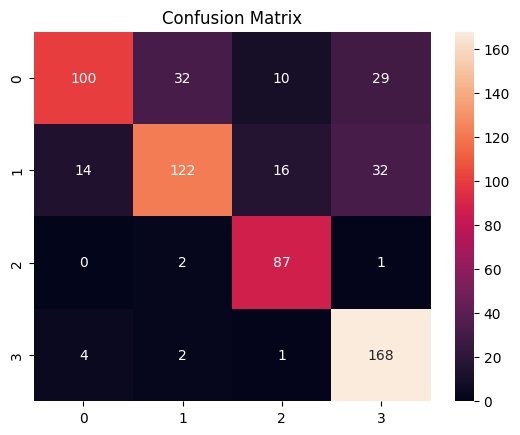

In [24]:
cm = confusion_matrix(y_true, y_predicted)

sns.heatmap(cm, annot=True,fmt=".0f")
plt.title("Confusion Matrix")
plt.show()

### Classification Report

In [25]:
print(classification_report(y_true,y_predicted))

              precision    recall  f1-score   support

           0       0.85      0.58      0.69       171
           1       0.77      0.66      0.71       184
           2       0.76      0.97      0.85        90
           3       0.73      0.96      0.83       175

    accuracy                           0.77       620
   macro avg       0.78      0.79      0.77       620
weighted avg       0.78      0.77      0.76       620



* **Accuracy Score: 0.84**
* **f1-score for 0: 0.69**
* **f1-score for 1: 0.71**
* **f1-score for 2: 0.85**
* **f1-score for 3: 0.83**

### Using Pre-trained model InceptionV3

In [26]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [27]:
inceptionv3 = InceptionV3(input_shape=(256,256,3), weights='imagenet', include_top=False)

for layer in inceptionv3.layers:
    layer.trainable = False
    
x = keras.layers.Flatten()(inceptionv3.output)

prediction = keras.layers.Dense(4, activation='softmax')(x)

model4 = keras.Model(inputs=inceptionv3.input, outputs=prediction)

87910968/87910968 [==============================] - 0s 0us/step


### Training our model

In [29]:
model4.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model4.fit(X_train, y_train, epochs=50, validation_split=0.2, batch_size=32, callbacks=[es])

Epoch 1/50
62/62 [==============================] - 20s 211ms/step - loss: 3.3882 - accuracy: 0.6646 - val_loss: 2.2935 - val_accuracy: 0.7278
Epoch 2/50
62/62 [==============================] - 7s 114ms/step - loss: 0.6516 - accuracy: 0.8949 - val_loss: 1.3087 - val_accuracy: 0.8165
Epoch 3/50
62/62 [==============================] - 7s 113ms/step - loss: 0.3144 - accuracy: 0.9354 - val_loss: 1.3479 - val_accuracy: 0.8306
Epoch 4/50
62/62 [==============================] - 7s 113ms/step - loss: 0.1406 - accuracy: 0.9727 - val_loss: 1.3430 - val_accuracy: 0.8488
Epoch 5/50
62/62 [==============================] - 7s 112ms/step - loss: 0.0820 - accuracy: 0.9788 - val_loss: 1.3428 - val_accuracy: 0.8508
Epoch 6/50
62/62 [==============================] - 7s 112ms/step - loss: 0.1336 - accuracy: 0.9682 - val_loss: 0.7705 - val_accuracy: 0.8649
Epoch 7/50
62/62 [==============================] - 8s 129ms/step - loss: 0.0478 - accuracy: 0.9879 - val_loss: 1.1289 - val_accuracy: 0.8609
Epoch

### Prediction for X_test

In [30]:
y_pred = model4.predict(X_test)
y_predicted = np.argmax(y_pred, axis=1)

20/20 [==============================] - 5s 157ms/step


### Accuracy Score

In [31]:
accuracy_score(y_true,y_predicted)

0.8774193548387097

### Confusion Matrix

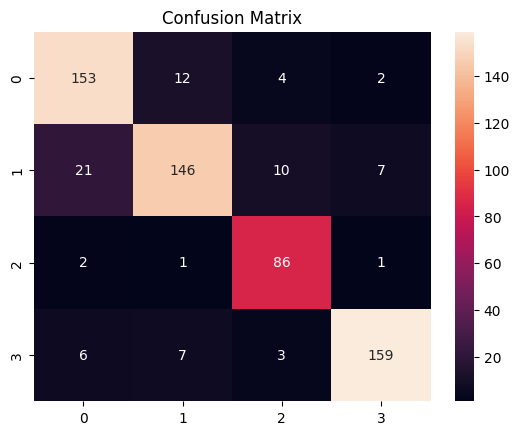

In [32]:
cm = confusion_matrix(y_true, y_predicted)

sns.heatmap(cm, annot=True,fmt=".0f")
plt.title("Confusion Matrix")
plt.show()

### Classification Report

In [33]:
print(classification_report(y_true,y_predicted))

              precision    recall  f1-score   support

           0       0.84      0.89      0.87       171
           1       0.88      0.79      0.83       184
           2       0.83      0.96      0.89        90
           3       0.94      0.91      0.92       175

    accuracy                           0.88       620
   macro avg       0.87      0.89      0.88       620
weighted avg       0.88      0.88      0.88       620



* **Accuracy Score: 0.88**
* **f1-score for 0: 0.87**
* **f1-score for 1: 0.83**
* **f1-score for 2: 0.89**
* **f1-score for 3: 0.92**

### Saving the model

We are saving model2 i.e. VGG16 because we are getting best result from that model.

In [57]:
model2.save("model.h5")